### Udacity Self-Driving Car Engineer Nanodegree
# Project 5 &mdash; Vehicle Detection 
--- 


## Overview

#### The goals and steps of this project are:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
1. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
  * Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
1. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
1. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
1. Estimate a bounding box for vehicles detected.

---

---

# Step 0 | Project Setup

## Imports

In [64]:
from collections import deque
import cv2
import glob
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
import os
import pickle
from scipy.ndimage.measurements import label
import skimage
from skimage import data, color, exposure
from skimage.feature import hog
from skimage.transform import resize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time

# Show plots in notebook
%matplotlib inline

## Data Import & Pre-processing
Here we import the dataset which contains vehicle and non-vehicle images with a resolution of 64x64. We also examine it to make sure it matches our expections. Then split the data and add the appropriate labels. 

In [70]:
vehicles = glob.glob("data/vehicles/*/*.png")
non_vehicles = glob.glob("data/non-vehicles/*/*.png")

# Read X Vector
X = []
for file in vehicles:    
    X.append(skimage.io.imread(file))
for file in non_vehicles:    
    X.append(skimage.io.imread(file))
X = np.array(X)

# Generate Y Vector
y = np.concatenate([np.ones(len(vehicles)), np.zeros(len(non_vehicles))])

# Split train and validation dataset with 10%
rand = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand)

# Show messages
print('X_train shape:', X_train.shape)
print('Training samples:', X_train.shape[0])
print('Test samples:', X_test.shape[0])

X_train shape: (15984, 64, 64, 3)
Training samples: 15984
Test samples: 1776


## Data Visualization &mdash; Preview Training Images & Labels
Here we do a quick spot check to make sure the images and labels match. 1 for vehicle, 0 for non-vehicle

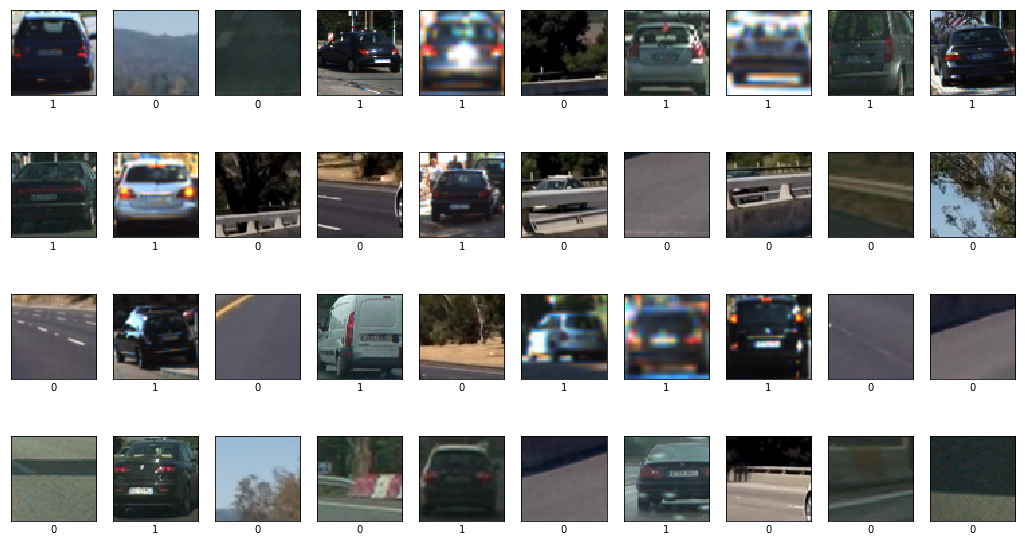

In [12]:
def previewImages(n):
    fig = plt.figure(figsize=(18, 10))
    for i in range(0, n):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(4,10,i+1)
        axis.set_xlabel(int(Y_train[number]))
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        axis.imshow(X_train[number])
    plt.show()

previewImages(40)

## Data Distribution
Here we check to make sure the data distribution is balanced.

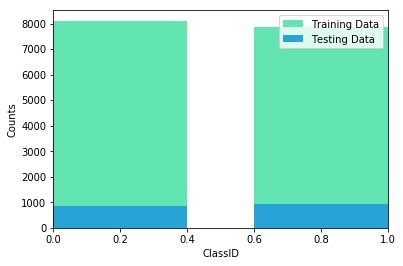

In [26]:
def showDistribution():
    _, training_counts = np.unique(y_train, return_counts = True)
    _, test_counts = np.unique(y_test, return_counts = True)
    plt.bar( np.arange( 2 ), training_counts,   color='#62E5B1', label='Training Data')
    plt.bar( np.arange( 2 ), test_counts,  color='#28A3D8', label='Testing Data')
    plt.xlabel('ClassID')
    plt.ylabel('Counts')
    plt.xlim([0, 1])
    plt.legend()
    plt.show()
    
showDistribution()

## Helper Functions
These are the functions used during the lecture exercises.

In [67]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Step 1 | Histogram of Oriented Gradients (HOG)
Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier


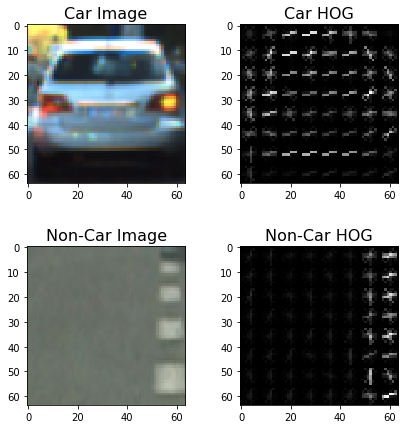

In [62]:
randint = np.random.randint(0, len(non_vehicles))

car_img = mpimg.imread(vehicles[randint])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

noncar_img = mpimg.imread(non_vehicles[randint])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

# Step 2 | 
Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

In [71]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()

car_features = extract_features(vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_vehicles, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors



52.65 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 64


In [73]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [74]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Step 3 | 
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.


# Step 4 | 
Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.


# Step 5 | 
Estimate a bounding box for vehicles detected.

---
# Explorations
---

## CNN Approach

Create the all-convolutional network and add a flatten layer at the end for training

In [ ]:
def create_model(input_shape=(64,64,3)):
    model = Sequential()
    # Center and normalize our data
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    # 1st conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))  
    model.add(Dropout(0.5))
    # 2nd conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2',border_mode="same"))
    model.add(Dropout(0.5))
    # 3rd conv layer with 128 filter, 3x3 each, 8x8 pooling and dropout
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv3',border_mode="same"))
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.5))
    # This acts like a 128 neuron dense layer
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) 
    model.add(Dropout(0.5))
    # This is like a 1 neuron dense layer with tanh [-1, 1]
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) 
    
    return model

model = create_model()
model.summary()
model.add(Flatten())

Train the network using the dataset, ONLY DO THIS ONCE

In [ ]:
# Plot the results of the training
def plot_results(history):
    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

model.compile(loss='mse',optimizer='rmsprop',metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=2, validation_data=(X_test, Y_test))

plot_results(history)

model.save_weights('./dataset/model.h5')

Load the weights from the trained network

In [ ]:
# Load the fine-tuned for the final network
model.load_weights('./dataset/model.h5')
print("Weights loaded!")

Initialize the weights for the network and try it on a sample image

In [ ]:
# Pick a random image from the test set
rand = np.random.randint(X_test.shape[0])
plt.imshow(X_test[rand])

# Predict the correct label
sample = np.reshape(X_test[rand], (1, 64,64,3))
prediction = model.predict(sample, batch_size=64, verbose=0)
prediction = prediction[0][0]

# Check if the prediction is a car or a non-car
if prediction >= 0.5:
    print("NN Prediction: CAR with value " + str(prediction))
else:
    print("NN Prediction: NO CAR with value " + str(prediction))
    
# Compare with the ground-truth
truth = Y_test[rand]
if truth == 1:
    print("Ground-truth: CAR with value " + str(truth))
else:
    print("Ground-truth: NO CAR with value " + str(truth))

We load a sample image to test our neural network on

In [ ]:
# Load a specific sample image
img = skimage.io.imread('./test_images/test4.jpg')

# Display it
fig = plt.figure(figsize=(12,20))
plt.imshow(img)

Search for cars in the image using the neural network, create bounding boxes for each hit

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def search_cars(img):
    # We crop the image to 440-660px in the vertical direction
    cropped = img[400:660, 0:1280]
    heat = heatmodel.predict(cropped.reshape(1,cropped.shape[0],cropped.shape[1],cropped.shape[2]))
    # This finds us rectangles that are interesting
    xx, yy = np.meshgrid(np.arange(heat.shape[2]),np.arange(heat.shape[1]))
    x = (xx[heat[0,:,:,0]>0.9999999])
    y = (yy[heat[0,:,:,0]>0.9999999])
    hot_windows = []
    # We save those rects in a list
    for i,j in zip(x,y):
        hot_windows.append(((i*8,400 + j*8), (i*8+64,400 +j*8+64)))
    return hot_windows

# Init a version of our network with another resolution without the flatten layer
heatmodel = create_model((260, 1280, 3))
# Load the weights
heatmodel.load_weights('./dataset/model.h5')

# Search for our windows
hot_windows = search_cars(img)

# Draw the found boxes on the test image
window_img = draw_boxes(img, hot_windows, (0, 255, 0), 6)                    

# Show the image with the windows on top
fig = plt.figure(figsize=(12,20))
plt.imshow(window_img)

Create a heatmap out of the found bounding boxes, threshold it and find the final bounding boxes

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

# Create image for the heat similar to one shown above 
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
boxes = label(heatmap)

# Create the final image
draw_img = draw_labeled_bboxes(np.copy(img), boxes)

# Show the car positions and the heat map with threshold applied
fig = plt.figure(figsize=(12,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

# Print information about the cars found
print(boxes[1], 'cars found')
fig = plt.figure(figsize=(12,20))
plt.imshow(boxes[0], cmap='gray')

This pipeline identifies the area inside two lanes and draws a blue polygon on top of it

In [ ]:
# Define the source points
src_points = np.float32([[0 , 720],
                         [1280 , 720],
                         [750 , 470],
                         [530 , 470]])

# Define the destination points
dst_points = np.float32([[320 , 720],
                         [960 , 720],
                         [960 , 0],
                         [320 , 0]])
# Storing our averages
prev_frames = []
prev_curvatures = []
prev_car_off = []

def region_of_interest(img,vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def applyTransformation(img):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    # Warp the image using OpenCV warpPerspective()
    transformed = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    # Return transformed image
    return transformed

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, thresh_min=0, thresh_max=255):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=9)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output

def applySobelMask(img):
    # Convert to HLS and extract L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Apply sobel in x direction on L and S channel
    l_channel_sobel_x = abs_sobel_thresh(l_channel,'x', 20, 200)
    s_channel_sobel_x = abs_sobel_thresh(s_channel,'x', 60, 200)
    sobel_combined_x = cv2.bitwise_or(s_channel_sobel_x, l_channel_sobel_x)
    
    # Apply magnitude sobel
    l_channel_mag = mag_thresh(l_channel, 80, 200)
    s_channel_mag = mag_thresh(s_channel, 80, 200)
    mag_combined = cv2.bitwise_or(l_channel_mag, s_channel_mag)
    
    # Combine all the sobel filters
    mask_combined = cv2.bitwise_or(mag_combined, sobel_combined_x)
    
    # Mask out the desired image and filter image again
    mask_combined = region_of_interest(mask_combined, np.array([[(330, 0),(950, 0), (950, 680), (330, 680)]]))
    
    # Return the sobel mask
    return mask_combined

def applyColorMask(img):
    # Convert to HLS and extract S and V channel
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define color thresholds in HSV
    white_low = np.array([[[0, 0, 210]]])
    white_high = np.array([[[255, 30, 255]]])

    yellow_low = np.array([[[18, 80, 80]]])
    yellow_high = np.array([[[30, 255, 255]]])

    # Apply the thresholds to get only white and yellow
    white_mask = cv2.inRange(img_hsv, white_low, white_high)
    yellow_mask = cv2.inRange(img_hsv, yellow_low, yellow_high)

    # Bitwise or the yellow and white mask
    color_mask = cv2.bitwise_or(yellow_mask, white_mask)
    return color_mask

def combineMasks(sobel_mask, color_mask):
    mask_combined = np.zeros_like(sobel_mask)
    mask_combined[(color_mask>=.5)|(sobel_mask>=.5)] = 1
    return mask_combined

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def slidingWindow(img):
    # Window settings
    window_width = 50
    window_height = 100
    # How much to slide left and right for searching
    margin = 30
    
    # Store the (left,right) window centroid positions per level
    window_centroids = [] 
    # Create our window template that we will use for convolutions
    window = np.ones(window_width) 
    
    # Find the starting point for the lines
    l_sum = np.sum(img[int(3*img.shape[0]/5):,:int(img.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(img[int(3*img.shape[0]/5):,int(img.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(img.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1, (int)(img.shape[0] / window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(img[int(img.shape[0]-(level+1)*window_height):int(img.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width / 2
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,img.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,img.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    
    # If we have found any window centers, print error and return
    if len(window_centroids) == 0:
        print("No windows found in this frame!")
        return
    
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(img)
    r_points = np.zeros_like(img)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((template, template, template)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((img, img, img)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
    # Extract left and right line pixel positions
    leftx = np.nonzero(l_points)[1]
    lefty = np.nonzero(l_points)[0]
    rightx = np.nonzero(r_points)[1]
    righty = np.nonzero(r_points)[0]
            
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Return left and right lines as well as the image
    return left_fit, right_fit, output

def calcCurvature(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Set y-value to bottom of the image
    y_eval = 719
    # Calculate left and right curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Match them together
    curverad = (left_curverad + right_curverad) / 2
    
    # Use the last ten values and build the average of them
    prev_curvatures.append(curverad)
    avg_curverad = np.average(prev_curvatures[-10:])
    
    # Return the average curvature in meter
    return avg_curverad

def calcCarOff(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Left and right line intercept on x axis
    left_intcpt = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_intcpt = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]

    # Calculate the middle of the lanes
    lane_mid = (left_intcpt + right_intcpt)/2.0

    # Calculate the offset
    car_off = (lane_mid - 1280/2.0)*xm_per_pix
    
    # Average over the last ten positions
    prev_car_off.append(car_off)
    avg_car_off = np.average(prev_car_off[-10:])
    
    return avg_car_off

def displayInfo(img, curverad, car_off):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    curve_disp_txt = 'Curvature: ' + str(np.round(curverad,2)) + 'm'
    off_disp_txt = 'Car offset: ' + str(np.round(car_off,2)) + 'm'
    cv2.putText(img, curve_disp_txt, (20, 30), font, 1, (0,0,0), 2)
    cv2.putText(img, off_disp_txt, (20, 60), font, 1, (0,0,0), 2)
    return img

def applyBackTrans(img, left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)
    # Calculate left and right x positions
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Defining a blank mask to start with
    polygon = np.zeros_like(img) 

    # Create an array of points for the polygon
    plot_y = np.linspace(0, img.shape[0]-1, img.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the polygon in blue
    cv2.fillPoly(polygon, np.int_([pts]), (0, 0, 255))
    
    # Calculate top and bottom distance between the lanes
    top_dist = right_fitx[0] - left_fitx[0]
    bottom_dist = right_fitx[-1] - left_fitx[-1]
    
    # Add the polygon to the list of last frames if it makes sense
    if len(prev_frames) > 0: 
        if top_dist < 300 or bottom_dist < 300 or top_dist > 500 or bottom_dist > 500:
            polygon = prev_frames[-1]
        else:
            prev_frames.append(polygon)
    else:
        prev_frames.append(polygon)
        
    # Check that the new detected lane is similar to the one detected in the previous frame
    polygon_gray = cv2.cvtColor(polygon, cv2.COLOR_RGB2GRAY) 
    prev_gray = cv2.cvtColor(prev_frames[-1], cv2.COLOR_RGB2GRAY)  
    non_similarity = cv2.matchShapes(polygon_gray,prev_gray, 1, 0.0)
    if non_similarity > 0.002: 
        polygon = prev_frames[-1]

    # Calculate the inverse transformation matrix
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    image_backtrans = cv2.warpPerspective(polygon, M_inv, (img.shape[1], img.shape[0])) 
    
    # Return the 8-bit mask
    return np.uint8(image_backtrans)

def findLanes(img):   
    # Copy and crop the image
    img_cropped = np.copy(img)
    img_cropped = region_of_interest(img_cropped, [src_points.astype(np.int32)])
    
    # Apply image transformation
    img_warped = applyTransformation(img_cropped)
    
    # Apply the sobel mask to the image
    img_sobel = applySobelMask(img_warped)
    
    # Apply the color mask to the image
    img_color = applyColorMask(img_warped)
    
    # Combine color and sobel mask
    img_mask = combineMasks(img_sobel, img_color)
    
    # Find the lines from polyfit
    left_fit, right_fit, _ = slidingWindow(img_mask)
    
    # Create the lane mask and apply backtransformation
    lane_mask = applyBackTrans(img, left_fit, right_fit)
    
    # Combine the sample image with the lane layer
    img_result = cv2.addWeighted(img, 1, lane_mask, 1, 0)
    
    # Add the information for the image
    curverad = calcCurvature(left_fit, right_fit)
    car_off = calcCarOff(left_fit, right_fit)
    img_info = displayInfo(img_result, curverad, car_off)
    return img_info

This is our final image pipeline, where we draw the bounding boxes on top of each frame and also identify the lane lines

In [ ]:
def process_image(img):      
    # Find the lane lines first
    img_lanes = findLanes(img)
    
    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Search for cars
    hot_windows = search_cars(img)

    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    boxes = label(heatmap)

    # Create the final image
    draw_img = draw_labeled_bboxes(img_lanes, boxes)
    
    # Return it to the video processing tool
    return draw_img

Apply the image pipeline to all test images

In [ ]:
# Repeat for all images
for index, image in enumerate(os.listdir("test_images/")):
    # Restore averages for every image
    prev_frames = []
    prev_curvatures = []
    prev_car_off = []
    
    # Read in image
    img = skimage.io.imread('test_images/' + image)
    
    # Let the image go through the pipeline
    img_lane = process_image(img)
    
    #Display the final image
    fig = plt.figure(figsize=(12,20))
    plt.imshow(img_lane)
    
    #Save it to file
    fig.savefig('output_images/' + image, bbox_inches='tight', pad_inches=0)

Pipeline for our videos with avering over several frames

In [ ]:
# Create history element
history = None

# Our video processing pipeline
def process_video(img):
    # Find the lane lines first
    img_lanes = findLanes(img)
    
    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Find the cars
    hot_windows = search_cars(img)

    # Create image for the heat similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    boxes = label(heatmap)
    
    # Iterate through all detected cars
    for car_number in range(1, boxes[1]+1):
        # Find pixels with each car_number label value
        nonzero = (boxes[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Append current boxe to history
        history.append([np.min(nonzerox),np.min(nonzeroy),np.max(nonzerox),np.max(nonzeroy)])
    
    # Get recent boxes for the last 30 fps
    recent_boxes = np.array(history).tolist()

    # Groups the object candidate rectangles with difference of 10%
    boxes = cv2.groupRectangles(recent_boxes, 10, .1)
    
    # Draw rectangles if found
    if len(boxes[0]) != 0:
        for box in boxes[0]:
            cv2.rectangle(img_lanes, (box[0], box[1]), (box[2],box[3]), (0,255,0), 6)
            
    # Return image with found cars and lanes
    return img_lanes

Process the project video and save it

In [ ]:
# Restore averages
prev_frames = []
prev_curvatures = []
prev_car_off = []
# Create history for 30 frames
history = deque(maxlen=30)
# Process the video
clip_output = 'output_videos/project_video.mp4'
clip = VideoFileClip("test_videos/project_video.mp4")
clip_process = clip.fl_image(process_video)
%time clip_process.write_videofile(clip_output, audio=False)